In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

In [2]:
def format_model_name(key):
    if 'rnn' in key:
        return 'RNN-SF'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [ ]:
def get_sparsity(key):
    p = re.compile('.*sparsity(.+?)\/.*')
    if 'sparsity' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

def get_sigma(key):
    p = re.compile('.*sigma(.+?)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

In [ ]:
hue_order = [
    'Linear',
    'RNN-SF',
    'MLP with Replay Buffer',
    #'RNN with Fixed LR', 'RNN with Dynamic LR',
    ]

# Collect aggregate metrics

In [ ]:
# Collect measures of all iterations
root_dir = "/home/chingf/engram/Ching/03_td_discrete_corr_v1/"

init_sparsities = []
sigmas = []
gammas = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []

for sparsity_dir in os.listdir(root_dir):
    if 'sparsity' not in sparsity_dir: continue
    for sigma_dir in os.listdir(f'{root_dir}{sparsity_dir}/'):
        for gamma_dir in os.listdir(f'{root_dir}{sparsity_dir}/{sigma_dir}/'):
            path = f'{root_dir}{sparsity_dir}/{sigma_dir}/{gamma_dir}/'
            
            # Get dataset parameters
            init_sparsity = get_sparsity(path)
            sigma = get_sigma(path)
            gamma = float(gamma_dir)
            
            # Iterate over models
            for model_dir in os.listdir(path):
                try:
                    model = format_model_name(model_dir)
                except:
                    continue
                model_path = f'{path}{model_dir}/'
                    
                # Gather metrics for each model iteration
                for iter_dir in os.listdir(model_path):
                    iter_path = model_path + iter_dir + '/'
                    for file in os.listdir(iter_path):
                        if 'tfevents' not in file: continue
                        tfevents_file = iter_path + '/' + file
                        event_acc = EventAccumulator(tfevents_file)
                        event_acc.Reload()
                        try:
                            scalar_events = event_acc.Scalars('loss_train')
                        except:
                            continue
                        values = np.array([event.value for event in scalar_events])
                        if np.any(np.isnan(values)): continue
                        steps = np.array([event.step for event in scalar_events])
                        central_diffs = values[1:] + values[:-1] - 2*values[:-1]
                        if values[0] > values[-1]: # decreasing
                            val95 = values[0] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values <= val95)[0][0]
                        else: # increasing
                            val95 = values[-1] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values >= val95)[0][0]
                            
                        init_sparsities.append(init_sparsity)
                        sigmas.append(sigma)
                        gammas.append(gamma)
                        models.append(model)
                        start_losses.append(values[0])
                        time_to_elbows.append(steps[time_to_95])
                        #time_to_elbows.append(steps[np.argmax(central_diffs)])
                        final_losses.append(values[-1])
                        break

init_sparsities = np.array(init_sparsities)
sigmas = np.array(sigmas)
gammas = np.array(gammas)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)

In [ ]:
# Collect best measures over all iterations
root_dir = "/home/chingf/engram/Ching/03_td_discrete_corr/"

init_sparsities = []
sigmas = []
gammas = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []

for sparsity_dir in os.listdir(root_dir):
    if 'sparsity' not in sparsity_dir: continue
    for sigma_dir in os.listdir(f'{root_dir}{sparsity_dir}/'):
        for gamma_dir in os.listdir(f'{root_dir}{sparsity_dir}/{sigma_dir}/'):
            path = f'{root_dir}{sparsity_dir}/{sigma_dir}/{gamma_dir}/'
            
            # Get dataset parameters
            init_sparsity = get_sparsity(path)
            sigma = get_sigma(path)
            gamma = float(gamma_dir)
            
            # Iterate over models
            for model_dir in os.listdir(path):
                try:
                    model = format_model_name(model_dir)
                except:
                    continue
                model_path = f'{path}{model_dir}/'
                    
                # Gather metrics for each model iteration
                best_val = np.inf
                best_set = [np.nan, np.nan, np.nan]
                for iter_dir in os.listdir(model_path):
                    iter_path = model_path + iter_dir + '/'
                    for file in os.listdir(iter_path):
                        if 'tfevents' not in file: continue
                        tfevents_file = iter_path + '/' + file
                        event_acc = EventAccumulator(tfevents_file)
                        event_acc.Reload()
                        scalar_events = event_acc.Scalars('loss_train')
                        values = np.array([event.value for event in scalar_events])
                        if np.any(np.isnan(values)): continue
                        steps = np.array([event.step for event in scalar_events])
                        central_diffs = values[1:] + values[:-1] - 2*values[:-1]
                        if values[0] > values[-1]: # decreasing
                            val95 = values[0] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values <= val95)[0][0]
                        else: # increasing
                            val95 = values[-1] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values >= val95)[0][0]
                        start_loss = values[0]
                        time_to_elbow = steps[time_to_95]
                        final_loss = values[-1]
                        if final_loss < best_val:
                            best_val = final_loss
                            best_set = [start_loss, time_to_elbow, final_loss]
                        break
                init_sparsities.append(init_sparsity)
                sigmas.append(sigma)
                gammas.append(gamma)
                models.append(model)
                start_losses.append(best_set[0])
                time_to_elbows.append(best_set[1])
                #time_to_elbows.append(steps[np.argmax(central_diffs)])
                final_losses.append(best_set[2])

init_sparsities = np.array(init_sparsities)
sigmas = np.array(sigmas)
gammas = np.array(gammas)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)

# Testing

In [2]:
from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP, Hopfield
from run_td_rnn import run as run_rnn

sparsity_p = 0.1
spatial_sigma = 3.0
num_states = input_size = 20*20
num_steps = 2000
dataset = sf_inputs_discrete.Sim2DWalk
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_type': 'correlated_distributed',
    'feature_vals_p': [1-sparsity_p, sparsity_p],
    'spatial_sigma': spatial_sigma
    }
dataset_config = {
    'num_steps': num_steps, 'feature_maker_kwargs': feature_maker_kwargs,
    'num_states': num_states
    }
dset = dataset(**dataset_config)

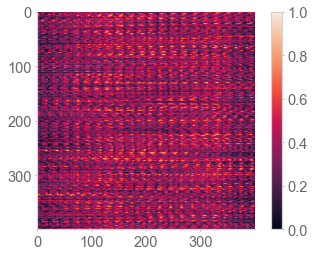

In [3]:
plt.figure()
plt.imshow(dset.feature_maker.feature_map)
plt.colorbar()
plt.show()

In [4]:
from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP, Hopfield
from run_td_rnn import run as run_rnn

arena_length = 20 #14
num_states = arena_length**2
num_steps= 5000
sparsity_p = 0.001 #0.022
spatial_sigma = 2.
feature_maker_kwargs = {
    'feature_dim': num_states,
    'feature_type': 'correlated_distributed',
    'feature_vals_p': [1-sparsity_p, sparsity_p],
    'spatial_sigma': spatial_sigma,
    'gaussian_truncate': 1.
    }
dataset_config = {
    'num_steps': num_steps,
    'feature_maker_kwargs': feature_maker_kwargs,
    'num_states': num_states
}
dataset = sf_inputs_discrete.Sim2DWalk
dset = dataset(**dataset_config)

net = AnalyticSR(
    num_states=num_states, gamma=0.75,
    ca3_kwargs={
        'use_dynamic_lr':False, #'lr': -0.02046,
        'output_params':{
            'num_iterations':int(np.log(1E-5)/np.log(0.75)), 'nonlinearity': 'clamp',
            #'nonlinearity_args': [-0.055744, 2.045]
            }, 'parameterize': True
        }
    )
_, _, _, net = run_rnn(
    'test/', net, dataset, dataset_config,
    gamma=0.75,
    train_net=True, test_over_all=False
    )

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=310942, Mon Jan  3 11:52:28 2022)

[    1] loss: 0.009
Time per step 284.300s, net 284.300s


KeyboardInterrupt: 

In [6]:
netT = AnalyticSR(
    num_states=input_size, gamma=0.6,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': 0.1,
        'output_params':{
            'num_iterations':25, 'nonlinearity': 'sigmoid',
            #'nonlinearity_args': [-0.055744, 2.045]
            }, 'parameterize': False
        }
    )
netT.ca3.sigmoid_a.fill_(0.9758)
netT.ca3.sigmoid_b.fill_(-2.0594)
netT.ca3.parameterize = True

In [ ]:
dataset_config = {
    'num_steps': 6000, 'feature_maker_kwargs': feature_maker_kwargs,
    'num_states': num_states
    }

out, loss, dset, _net = run_rnn(
    'test/', netT, dataset, dataset_config,
    gamma=0.6,
    train_net=False, test_over_all=False
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



[   51] loss: 0.007
Time per step 0.105s, net 5.234s

[  101] loss: 0.006
Time per step 0.147s, net 12.603s

[  151] loss: 0.007
Time per step 0.147s, net 19.961s

[  201] loss: 0.007
Time per step 0.153s, net 27.627s

[  251] loss: 0.007
Time per step 0.147s, net 35.001s

[  301] loss: 0.007
Time per step 0.148s, net 42.413s

[  351] loss: 0.007
Time per step 0.150s, net 49.914s

[  401] loss: 0.007
Time per step 0.151s, net 57.474s

[  451] loss: 0.006
Time per step 0.152s, net 65.052s

[  501] loss: 0.006
Time per step 0.152s, net 72.645s

[  551] loss: 0.006
Time per step 0.152s, net 80.261s

[  601] loss: 0.007
Time per step 0.152s, net 87.849s

[  651] loss: 0.007
Time per step 0.151s, net 95.374s

[  701] loss: 0.007
Time per step 0.152s, net 102.950s

[  751] loss: 0.007
Time per step 0.150s, net 110.462s

[  801] loss: 0.007
Time per step 0.151s, net 118.033s

[  851] loss: 0.007
Time per step 0.153s, net 125.693s

[  901] loss: 0.007
Time per step 0.151s, net 133.223s

[  95

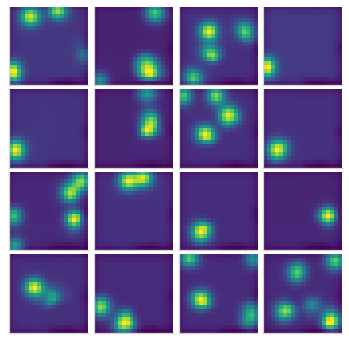

In [11]:
from utils import get_firing_field
from scipy import ndimage
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(out.shape[1])
np.random.shuffle(neurs)
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(dset.num_states))

idx = 0
for neur in neurs:
    ff, _ = get_firing_field(
        walk_xs, walk_ys, out[:,neur],
        arena_length, normalize=True
        )
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(ff/ff.max(), vmin=0., vmax=1, cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])

    idx += 1
    if idx == grid_x*grid_y: break
plt.show()

# Make barplots

In [67]:
df = pd.DataFrame({
    'Sparsity': init_sparsities,
    'Sigma': sigmas,
    'Gamma': gammas,
    'Model': models,
    'Start Loss': start_losses,
    'Time to Elbow': time_to_elbows/(configs.dt_to_sec*60),
    'Final Loss': final_losses
    })

In [68]:
np.unique(init_sparsities)

array(['0.002', '0.007103448275862068', '0.012206896551724133',
       '0.017310344827586227', '0.022413793103448293',
       '0.02751724137931036', '0.032620689655172425',
       '0.03772413793103449', '0.042827586206896556',
       '0.04793103448275862', '0.05303448275862069',
       '0.05813793103448277', '0.06324137931034483', '0.0683448275862069',
       '0.07344827586206897', '0.07855172413793103',
       '0.08365517241379311', '0.08875862068965518',
       '0.09386206896551724', '0.09896551724137931',
       '0.10406896551724137', '0.10917241379310344', '0.1142758620689655',
       '0.11937931034482759', '0.12448275862068965',
       '0.12958620689655173', '0.1346896551724138', '0.13979310344827586',
       '0.14489655172413793', '0.15'], dtype='<U20')

In [69]:
np.unique(gammas)

array([0.6 , 0.75, 0.8 ])

In [70]:
np.unique(sigmas)

array(['0.0', '0.5', '1.0', '1.25', '1.5', '1.75', '2.0', '2.25', '2.5',
       '2.75', '3.0', '3.25'], dtype='<U4')

<AxesSubplot:xlabel='Sigma', ylabel='Final Loss'>

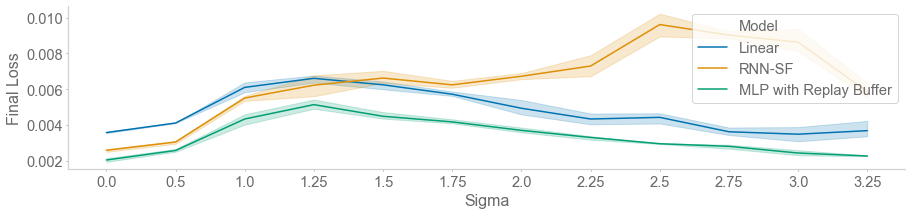

In [71]:
fig, ax = plt.subplots(figsize=(15,3))
sns.lineplot(
    x='Sigma', y='Final Loss', hue='Model',
    ax = ax, data=df[(df['Gamma']==0.6)&(df['Sparsity']=='0.007103448275862068')],
    hue_order=hue_order
    )
#ax.set_ylim(0,0.05)

(0.0, 0.05)

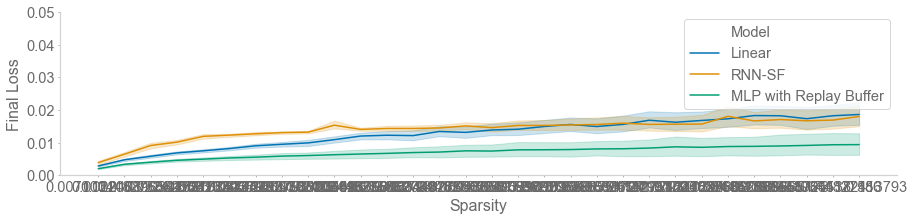

In [74]:
fig, ax = plt.subplots(figsize=(15,3))
sns.lineplot(
    x='Sparsity', y='Final Loss', hue='Model',
    ax = ax, data=df[df['Gamma']==0.6],
    hue_order=hue_order
    )
ax.set_ylim(0, 0.05)

(0.0, 0.05)

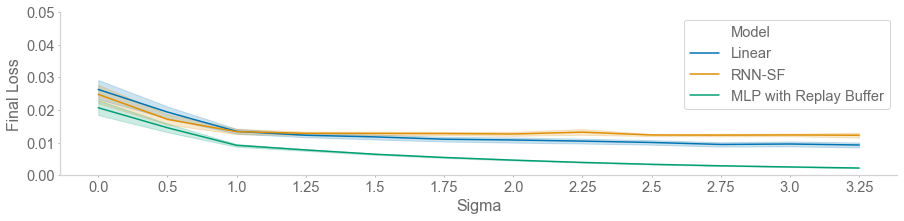

In [75]:
fig, ax = plt.subplots(figsize=(15,3))
sns.lineplot(
    x='Sigma', y='Final Loss', hue='Model',
    ax = ax, data=df[df['Gamma']==0.6],
    hue_order=hue_order
    )
ax.set_ylim(0, 0.05)

# Make 2D plots

In [7]:
np.unique(models)

array(['RNN-SF'], dtype='<U6')

In [20]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

In [32]:
def make_gradients(
    xs, ys, zs, models, cmap="Reds", interpolate=False,
    title=None, xlabel=None, ylabel=None, figname=None,
    smooth=False, contourz=None, figsize=[6.4, 4.8],
    plottype='relative'
    ):
    
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            rnn_idx = np.logical_and(
                np.logical_and(xs==x[i,j], ys==y[i,j]),
                models=='RNN-SF'
                )
            lin_idx = np.logical_and(
                np.logical_and(xs==x[i,j], ys==y[i,j]),
                models=='Linear'
                )
            mlp_idx = np.logical_and(
                np.logical_and(xs==x[i,j], ys==y[i,j]),
                models=='MLP with Replay Buffer'
                )
            rnn_val = np.nanmean(zs[rnn_idx])
            lin_val = np.nanmean(zs[lin_idx])
            mlp_val = np.nanmean(zs[mlp_idx])
            if plottype == 'relative':
                val = (rnn_val - mlp_val)/(lin_val - mlp_val)
                val = min(val, 10)
            elif plottype == 'rnn':
                val = rnn_val
            elif plottype == 'linear':
                val = lin_val
            elif plottype == 'mlp':
                val = mlp_val
            else:
                raise ValueError('Not valid plot type.')
            z[i,j] = val

    levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots()
    if plottype == 'relative':
        im = ax.pcolormesh(
            x.astype(float), y.astype(float), z,
            cmap=plt.cm.seismic, vmin=1-(np.abs(z).max()-1), vmax=1+(np.abs(z).max()-1)
            )
    else:
        im = ax.pcolormesh(
            x.astype(float), y.astype(float), z
            )
    fig.colorbar(im, ax=ax)
    ax.set_title('pcolormesh with levels')
    plt.show()
            
    if interpolate:
        nan_mask = np.isnan(z)
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X.astype(float), data_y.astype(float))

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten().astype(float),
                 y[nan_mask].flatten().astype(float)]).T
                )
            z[nan_mask] = interp_vals
        
    if smooth:
        from scipy.ndimage.filters import gaussian_filter
        z = gaussian_filter(z, 1.)
        
    #levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
    
    # contours are *point* based plots, so convert our bound into point
    # centers
    fig, ax = plt.subplots(figsize=figsize)
    if plottype == 'relative':
        cf = ax.contourf(x.astype(float),#[:-1, :-1] + dx/2.,
                         y.astype(float),#[:-1, :-1] + dy/2.,
                         z, levels=levels,
                         cmap=plt.cm.seismic, vmin=1-(np.abs(z).max()-1), vmax=1+(np.abs(z).max()-1)
                         )
    else:
        cf = ax.contourf(x.astype(float),#[:-1, :-1] + dx/2.,
                         y.astype(float),#[:-1, :-1] + dy/2.,
                         z, levels=levels
                         )
    if contourz is not None:
        cntrs = plt.contour(
            x.astype(float), y.astype(float), contourz, [1.0],
            colors='dimgray'
            )
        plt.clabel(cntrs, inline=True, fontsize=12)
    fig.colorbar(cf, ax=ax)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()
    
    return x, y, z

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


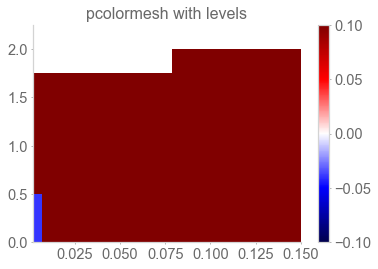

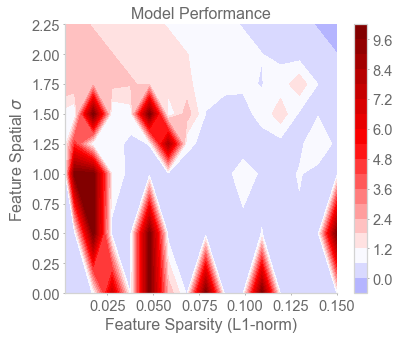

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


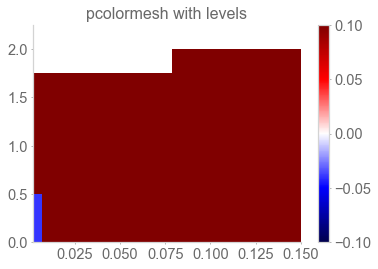

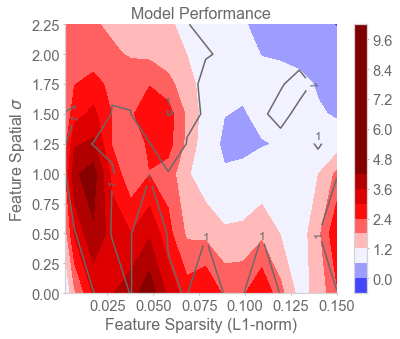

In [33]:
_gamma = 0.8
_models = models[gammas==_gamma]
_init_sparsities = init_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _init_sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5],
    plottype='relative'
    )

_x, _y, _z = make_gradients(
    _init_sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    contourz=_z, plottype='relative'
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


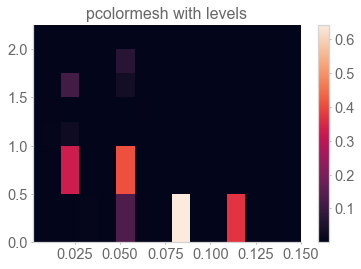

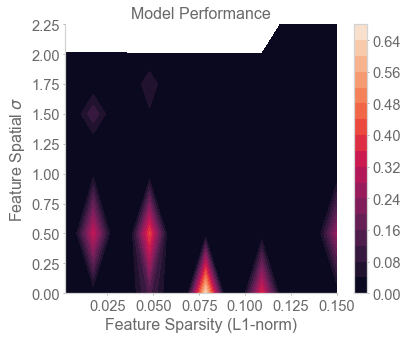

In [40]:
_gamma = 0.8
_models = models[gammas==_gamma]
_init_sparsities = init_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _init_sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5],
    plottype='rnn'
    )


/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


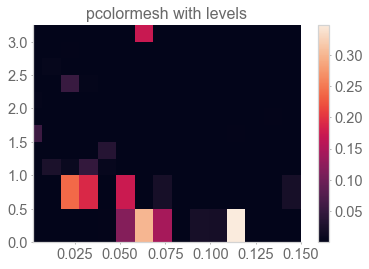

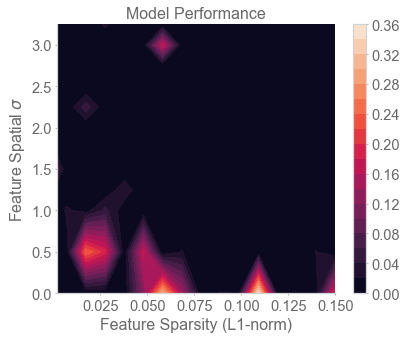

In [41]:
_gamma = 0.75
_models = models[gammas==_gamma]
_init_sparsities = init_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _init_sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5],
    plottype='rnn'
    )


/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


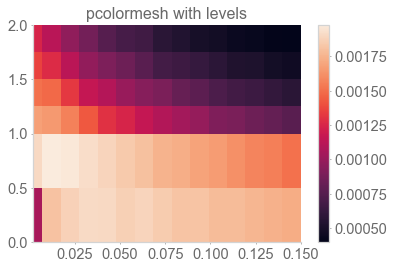

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/sklearn/utils/validation.py:755: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  estimator=estimator)
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/sklearn/linear_model/_base.py:207: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  X = check_array(X, accept_sparse=['csr', 'csc', 'coo'])


UFuncTypeError: ufunc 'matmul' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [17]:
_gamma = 0.75
_models = models[gammas==_gamma]
_init_sparsities = init_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _init_sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5],
    plottype='linear'
    )


/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


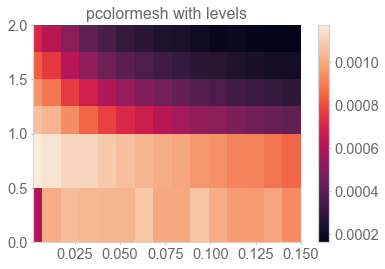

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/sklearn/utils/validation.py:755: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  estimator=estimator)
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/sklearn/linear_model/_base.py:207: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  X = check_array(X, accept_sparse=['csr', 'csc', 'coo'])


UFuncTypeError: ufunc 'matmul' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [18]:
_gamma = 0.75
_models = models[gammas==_gamma]
_init_sparsities = init_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _init_sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5],
    plottype='mlp'
    )
